# Fine Tuning BERT for Question Answering

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 73.5 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 67.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import os
import pickle
import numpy as np
from transformers import TFBertForQuestionAnswering
from transformers import BertTokenizer, TFBertModel
import json
import pandas as pd
os.chdir('/content/drive/MyDrive/CS6910 Folder Team 29/Assignment 4/QA dataset')

In [ ]:
X = pd.read_csv('Question-answering.csv', sep = ',', encoding='utf-8', index_col=None)
X_train = X.loc[1001:2000].reset_index()
del X_train['index']
np.random.seed(42)
X_train = X_train.sample(frac = 1).reset_index()

X_val = X.loc[9400:9599].reset_index()
del X_val['index']
np.random.seed(22)
X_val = X_val.sample(frac = 1).reset_index()

X_test = X.loc[9600:9749].reset_index()
del X_test['index']
np.random.seed(96)
X_test = X_test.sample(frac = 1).reset_index()

In [ ]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue May 31 06:10:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |   1475MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tqdm import tqdm
import string
def preprocess_data(X, tokenizer, path = 'processed_data/pickle/'):
    N = X.shape[0]
    for i in tqdm(range(N)):
        context = X.loc[i]['Context']#.translate(str.maketrans('', '', string.punctuation))
        context += ' nr'
        QAS = X.loc[i]['QuestionAnswerSets']
        tmp = QAS.split('<|"Question" ->')[1:]
        # q = []
        for j in range(len(tmp)):
            d = {}
            tmp1 = tmp[j].split(', "Answers" -> ')
            q = tmp1[0].strip()[1:-1]#.translate(str.maketrans('', '', string.punctuation))
            # if q == '\\':
            #     q = tmp[j].split('"')[2]
            # ques.append(q)
            t = tokenizer(q, context, return_tensors="tf")
            d['input_ids'] = t['input_ids']
            d['token_type_ids'] = t['token_type_ids']
            d['attention_mask'] = t['attention_mask']

            a1 = tmp1[1][:tmp1[1].index('}')][2:-1]#.translate(str.maketrans('', '', string.punctuation))
            start = int(tmp[j].split('"AnswerPositions" ->')[1].split('}')[0][2:]) - 1
            end = start + len(a1)
            a2 = context[start:end]

            d['y'] = z = tokenizer(a2, return_tensors="tf")['input_ids']
            a = t['input_ids'][0]
            y = z[0][1:-1]
            flag = 0
            for x in range(1, len(a)-len(y)):
                if sum(tf.cast(a[x:x+len(y)] == y, dtype = tf.int64)) == len(y):
                    s = x
                    flag = 1
                    start_positions = tf.constant([s])
            if flag == 0:
                s = 1
                start_positions = end_positions = tf.constant([len(a) - 2])
            else:
                end_positions = tf.constant([s+len(y) - 1])
            d['start_positions'] = start_positions
            d['end_positions'] = end_positions
            # break
        # break
            pickle.dump(d, open(path + 'qa_' + str(i) + str(j) + '.pkl', 'wb'))


def _int_feature(value):
    # print(value)
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _serialize_example(input_ids, token_type_ids, attention_mask, y, start_positions, end_positions):

    d_feature = {}
    d_feature['input_ids'] = _int_feature(tf.reshape(input_ids, -1))
    d_feature['token_type_ids'] = _int_feature(tf.reshape(token_type_ids, -1))
    d_feature['attention_mask'] = _int_feature(tf.reshape(attention_mask, -1))
    d_feature['y'] = _int_feature(tf.reshape(y, -1))
    d_feature['start_positions'] = _int_feature(tf.reshape(start_positions, -1))
    d_feature['end_positions'] = _int_feature(tf.reshape(end_positions, -1))


    example = tf.train.Example(features=tf.train.Features(feature=d_feature))
    return example.SerializeToString()

def create_tf_record(filepath = 'processed_data/pickle/', tf_path = 'processed_data/train.tfrecords'):
    names = os.listdir(filepath)
    writer = tf.io.TFRecordWriter(tf_path)
    for name in tqdm(names):
        d = pickle.load(open(filepath + name, 'rb'))
        input_ids = d['input_ids']    
        token_type_ids = d['token_type_ids']    
        attention_mask = d['attention_mask']    
        y = d['y']  
        start_positions = d['start_positions']  
        end_positions = d['end_positions']
        example = _serialize_example(input_ids, token_type_ids, attention_mask, y, start_positions, end_positions)
        writer.write(example)

    

In [ ]:
# preprocess_data(X_train, tokenizer)
# create_tf_record()

# preprocess_data(X_val, tokenizer, path = 'processed_data/pickle_val/')
# create_tf_record(filepath = 'processed_data/pickle_val/', tf_path = 'processed_data/val.tfrecords')

# preprocess_data(X_test, tokenizer, path = 'processed_data/pickle_test/')
# create_tf_record(filepath = 'processed_data/pickle_test/', tf_path = 'processed_data/test.tfrecords')

In [ ]:
def _parse_function(serialized):
    features = {
        "input_ids": tf.io.VarLenFeature(dtype=tf.int64),
        "token_type_ids": tf.io.VarLenFeature(dtype=tf.int64),
        "attention_mask": tf.io.VarLenFeature(dtype=tf.int64),
        "y": tf.io.VarLenFeature(dtype=tf.int64),
        "start_positions": tf.io.VarLenFeature(dtype=tf.int64),
        "end_positions": tf.io.VarLenFeature(dtype=tf.int64)
    }

    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)
    input_ids = tf.cast(parsed_example['input_ids'], tf.int64)
    input_ids = tf.sparse.to_dense(input_ids)
    token_type_ids = tf.cast(parsed_example['token_type_ids'], tf.int64)
    token_type_ids = tf.sparse.to_dense(token_type_ids)
    attention_mask = tf.cast(parsed_example['attention_mask'], tf.int64)
    attention_mask = tf.sparse.to_dense(attention_mask)
    y = tf.cast(parsed_example['y'], tf.int64)
    y = tf.sparse.to_dense(y)
    start_positions = tf.cast(parsed_example['start_positions'], tf.int64)
    start_positions = tf.sparse.to_dense(start_positions)
    end_positions = tf.cast(parsed_example['end_positions'], tf.int64)
    end_positions = tf.sparse.to_dense(end_positions)
    # print(tf.expand_dims(start_positions, axis = 1).shape)
    positions = tf.concat((tf.expand_dims(start_positions, axis = 1), tf.expand_dims(end_positions, axis = 1)), axis = 0)

    d = {'input_ids':input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
    # y = {'start_positions': start_positions, 'end_positions':end_positions}
    # y = {'positions':positions}

    
    return d, positions

def get_batched_dataset(filenames ='processed_data/train.tfrecords', batch_size=4):
    # settings to read from all the shards in parallel
    AUTO = tf.data.experimental.AUTOTUNE
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    # list all files
    filenames = tf.io.gfile.glob(filenames)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)

    # Parse the serialized data in the TFRecords files.
    dataset = dataset.map(lambda x: _parse_function(x))
    dataset = dataset.padded_batch(batch_size)
    dataset = dataset.shuffle(500, reshuffle_each_iteration=True)

    return dataset

# Q/A model using BERT

## Model Class

In [ ]:
from tensorflow.keras.losses import Loss
class QA_loss(Loss):

  def call(self, y_true, y_pred):
    y_true = tf.squeeze(y_true, axis = 2)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction=tf.keras.losses.Reduction.NONE)(y_true, tf.transpose(y_pred, perm = (0, 2, 1)))
    loss = tf.reduce_sum(loss, axis = 1)
    loss = tf.reduce_mean(loss)
    return loss

In [ ]:
class BERT_QA(object):
    def __init__(self, bert_model, lr = 1e-3):
        self.build_model(bert_model, lr)
    def build_model(self, bert_model, lr):
        input_ids = tf.keras.layers.Input(shape = (None,), name = 'input_ids', dtype = tf.int64)
        token_type_ids = tf.keras.layers.Input(shape = (None,), name = 'token_type_ids', dtype = tf.int64)
        attention_mask = tf.keras.layers.Input(shape = (None,), name = 'attention_mask', dtype = tf.int64)
        
        d = {'input_ids':input_ids, 'token_type_ids':token_type_ids, 'attention_mask':attention_mask}
        bert_outputs = bert_model(d)
        bert_outputs['pooler_output'] = tf.stop_gradient(bert_outputs['pooler_output'])
        bert_output = bert_outputs['last_hidden_state']

        fc = tf.keras.layers.Dense(2, activation = 'linear', name = 'positions', use_bias=True)
        predictions = fc(bert_output)

        # fc1 = tf.keras.layers.Dense(1, activation = 'linear', name = 'start_positions', use_bias=False)
        # fc2 = tf.keras.layers.Dense(1, activation = 'linear', name = 'end_positions', use_bias=False)

        # start_pred = fc1(bert_output)
        # end_pred = fc2(bert_output)

        # loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
        # loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

        self.model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=predictions)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        # optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=1e-4)
        # self.model.compile(optimizer=optimizer, loss=[loss_fn1, loss_fn2], loss_weights = [1,1])
        # self.model.compile(optimizer=optimizer, loss=[loss_fn1, loss_fn2], loss_weights = [1,1])
        self.model.compile(optimizer=optimizer, loss = QA_loss())

        print(self.model.summary())
    def train(self, train_batch, val_batch, epochs, callbacks):
        history = self.model.fit(train_batch, epochs = epochs, callbacks = callbacks, validation_data = val_batch)
        return history

## Fine-Tuning

In [ ]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
tf.compat.v1.reset_default_graph()
model = BERT_QA(bert_model)
train_batch = get_batched_dataset()
val_batch = get_batched_dataset('processed_data/val.tfrecords')
test_batch = get_batched_dataset('processed_data/test.tfrecords')
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True, min_delta = 1e-7), 
            tf.keras.callbacks.ModelCheckpoint(filepath='models_2/model_new_29.{epoch:02d}-{val_loss:.2f}', save_format="tf", save_weights_only = True),
            tf.keras.callbacks.LearningRateScheduler(scheduler)]#, print_weights]

history = model.train(train_batch, val_batch, epochs = 15, callbacks=callbacks)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]',          

In [ ]:
for a, y in train_batch:
    print(y)
    break

tf.Tensor(
[[[20]
  [25]]

 [[80]
  [84]]

 [[66]
  [66]]

 [[79]
  [83]]], shape=(4, 2, 1), dtype=int64)


In [ ]:
QA_loss(y, tf.random.uniform((4, 90, 2)))

TypeError: ignored

## Evaluation

### Validation

In [ ]:
def predict(question, context, tokenizer, model):  
    inputs = tokenizer(question, context, return_tensors = 'tf')
    ps, pe = model.predict([inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']])
    start_ind = tf.math.argmax(ps[0])
    end_ind = tf.math.argmax(pe[0])
    # print(inputs['input_ids'])
    # print(start_ind.numpy())
    # print(end_ind.numpy())
    pred_tokens = inputs['input_ids'][0][start_ind.numpy()[0]:end_ind.numpy()[0] + 1]
    pred_answer = tokenizer.decode()
    return pred_tokens, pred_answer

In [ ]:
import collections
em_list = []
f1_list = []
examples_val = []
for inputs, outputs in tqdm(val_batch):
    batch_size = inputs['input_ids'].shape[0]
    ps, pe = model.model.predict([inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']])    
    for i in range(batch_size):
        start_ind = tf.math.argmax(ps[i])
        end_ind = tf.math.argmax(pe[i])

        true_start = outputs['start_positions'][i].numpy()[0]
        true_end = outputs['end_positions'][i].numpy()[0]

        if end_ind < start_ind:
            pred_tokens = tf.cast(tokenizer('nr', return_tensors='tf')['input_ids'][0], dtype = tf.int32)
        else:
            pred_tokens = tf.cast(inputs['input_ids'][i][start_ind.numpy()[0]:end_ind.numpy()[0] + 1], dtype = tf.int32)
        true_tokens = tf.cast(inputs['input_ids'][i][true_start:true_end+1], dtype = tf.int32)
        # print(true_tokens, pred_tokens)
        if len(true_tokens) != len(pred_tokens):
            em_list.append(0)
        elif tf.reduce_sum(tf.cast(true_tokens != pred_tokens, dtype = tf.int64)) > 0:
            em_list.append(0)
        else:
            em_list.append(1)
        tmp = sum((collections.Counter(list(true_tokens.numpy())) & collections.Counter(list(pred_tokens.numpy()))).values())
        if len(pred_tokens) == 0 or len(true_tokens) == 0 or tmp == 0:
            f1 = 0
        else:
            prec = tmp/len(pred_tokens)
            rec = tmp/len(true_tokens)
            f1 = 2 * prec * rec / (prec + rec)
        f1_list.append(f1)
        examples_val.append((tokenizer.decode(inputs['input_ids'][i]), tokenizer.decode(true_tokens), tokenizer.decode(pred_tokens)))
    # break

print('Average Validation EM: ', np.mean(em_list))
print('Average Validation F1: ', np.mean(f1_list))


365it [00:58,  6.29it/s]

Average Validation EM:  0.0006863417982155113
Average Validation F1:  0.04461892979369322


### Test

In [ ]:
import collections
em_list = []
f1_list = []
examples_test = []
test_loss = []
L = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
for inputs, outputs in tqdm(test_batch):
    batch_size = inputs['input_ids'].shape[0]
    ps, pe = model.model.predict([inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']])
    test_loss.append(L(outputs['start_positions'], tf.squeeze(ps)) + L(outputs['end_positions'], tf.squeeze(pe)))    
    for i in range(batch_size):
        start_ind = tf.math.argmax(ps[i])
        end_ind = tf.math.argmax(pe[i])

        true_start = outputs['start_positions'][i].numpy()[0]
        true_end = outputs['end_positions'][i].numpy()[0]

        if end_ind < start_ind:
            pred_tokens = tf.cast(tokenizer('nr', return_tensors='tf')['input_ids'][0], dtype = tf.int32)
        else:
            pred_tokens = tf.cast(inputs['input_ids'][i][start_ind.numpy()[0]:end_ind.numpy()[0] + 1], dtype = tf.int32)
        true_tokens = tf.cast(inputs['input_ids'][i][true_start:true_end+1], dtype = tf.int32)
        # print(true_tokens, pred_tokens)
        if len(true_tokens) != len(pred_tokens):
            em_list.append(0)
        elif tf.reduce_sum(tf.cast(true_tokens != pred_tokens, dtype = tf.int64)) > 0:
            em_list.append(0)
        else:
            em_list.append(1)
        tmp = sum((collections.Counter(list(true_tokens.numpy())) & collections.Counter(list(pred_tokens.numpy()))).values())
        if len(pred_tokens) == 0 or len(true_tokens) == 0 or tmp == 0:
            f1 = 0
        else:
            prec = tmp/len(pred_tokens)
            rec = tmp/len(true_tokens)
            f1 = 2 * prec * rec / (prec + rec)
        f1_list.append(f1)
        examples_test.append((tokenizer.decode(inputs['input_ids'][i]), tokenizer.decode(true_tokens), tokenizer.decode(pred_tokens)))

    # break

print('Average Test EM: ', np.mean(em_list))
print('Average Test F1: ', np.mean(f1_list))
print('Average Test Loss: ', np.mean(test_loss))


202it [00:29,  6.83it/s]

Average Test EM:  0.0012376237623762376
Average Test F1:  0.07250895383264372
Average Test Loss:  10.628829


### Training

In [ ]:
import collections
em_list = []
f1_list = []
examples_train = []
for inputs, outputs in tqdm(train_batch):
    batch_size = inputs['input_ids'].shape[0]
    ps, pe = model.model.predict([inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']])    
    for i in range(batch_size):
        start_ind = tf.math.argmax(ps[i])
        end_ind = tf.math.argmax(pe[i])

        true_start = outputs['start_positions'][i].numpy()[0]
        true_end = outputs['end_positions'][i].numpy()[0]

        if end_ind < start_ind:
            pred_tokens = tf.cast(tokenizer('nr', return_tensors='tf')['input_ids'][0], dtype = tf.int32)
        else:
            pred_tokens = tf.cast(inputs['input_ids'][i][start_ind.numpy()[0]:end_ind.numpy()[0] + 1], dtype = tf.int32)
        true_tokens = tf.cast(inputs['input_ids'][i][true_start:true_end+1], dtype = tf.int32)
        # print(true_tokens, pred_tokens)
        if len(true_tokens) != len(pred_tokens):
            em_list.append(0)
        elif tf.reduce_sum(tf.cast(true_tokens != pred_tokens, dtype = tf.int64)) > 0:
            em_list.append(0)
        else:
            em_list.append(1)
        tmp = sum((collections.Counter(list(true_tokens.numpy())) & collections.Counter(list(pred_tokens.numpy()))).values())
        if len(pred_tokens) == 0 or len(true_tokens) == 0 or tmp == 0:
            f1 = 0
        else:
            prec = tmp/len(pred_tokens)
            rec = tmp/len(true_tokens)
            f1 = 2 * prec * rec / (prec + rec)
        f1_list.append(f1)
        examples_train.append((tokenizer.decode(inputs['input_ids'][i]), tokenizer.decode(true_tokens), tokenizer.decode(pred_tokens)))

    # break

print('Average Train EM: ', np.mean(em_list))
print('Average Train F1: ', np.mean(f1_list))


1158it [02:26,  7.89it/s]

Average Train EM:  0.0
Average Train F1:  0.0285546113973101


### Examples

In [ ]:
import pickle
pickle.dump([examples_train, examples_val, examples_test], open('examples.pkl', 'wb'))

In [ ]:
examples_train[456], examples_train[450]

(('[CLS] what is the lowest nighttime temperature recorded at st. barts? [SEP] the island covers an area of 25 square kilometres ( 2, 500 ha ). the eastern side is wetter than the western. although the climate is essentially arid, the rainfall does average 1000 mm annually, but with considerable variation over the terrain. summer is from may to november, which is also the rainy season. winter from december to april is the dry season. sunshine is very prominent for nearly the entire year and even during the rainy season. humidity, however, is not very high due to the winds. the average temperature is around 25 °c with day temperatures rising to 32 °c. the average high and low temperatures in january are 28 °c and 22 °c, respectively, while in july they are 30 °c and 24 °c. the lowest night temperature recorded is 13 °c. the caribbean sea waters in the vicinity generally maintain a temperature of about 27 °c. nr [SEP]',
  '13 °c',
  'nighttime temperature recorded at st.'),
 ('[CLS] when

In [ ]:
examples_val[50], examples_val[100]

(('[CLS] what was the original name of the college street music hall? [SEP] the city hosts numerous theatres and production houses, including the yale repertory theatre, the long wharf theatre, and the shubert theatre. there is also theatre activity from the yale school of drama, which works through the yale university theatre and the student - run yale cabaret. southern connecticut state university hosts the lyman center for the performing arts. the shuttered palace theatre ( opposite the shubert theatre ) is being renovated and will reopen as the college street music hall in may, 2015. smaller theatres include the little theater on lincoln street. cooperative arts and humanities high school also boasts a state - of - the - art theatre on college street. the theatre is used for student productions as well as the home to weekly services to a local non - denominational church, the city church new haven. nr [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
  'palace theatre',

In [ ]:
examples_test[6], examples_test[122]


(('[CLS] what cities influenced how department stores in germany operated? [SEP] the design and function of department stores in germany followed the lead of london, paris and new york. germany used to have a number of department stores ; nowadays only a few of them remain. next to some smaller, independent department stores these are karstadt ( in 2010 taken over by nicolas berggruen, also operating the kadewe in berlin, the alsterhaus in hamburg and the oberpollinger in munich ), galeria kaufhof ( part of the metro ag ). others like hertie, wertheim and horten ag were taken over by others and either fully integrated or later closed. nr [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

## Plots

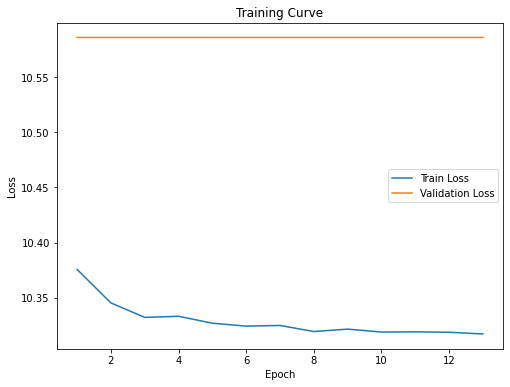

In [ ]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
E = len(train_loss)
plt.figure(figsize = (8, 6))
plt.plot(range(1, E + 1), train_loss, label = 'Train Loss')
plt.plot(range(1, E + 1), val_loss, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.legend(loc = 'best')
plt.savefig('Plots/training_curve.png', dpi = 400)

In [ ]:
a = tf.random.uniform((10, 1))
a

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.2761432 ],
       [0.03962076],
       [0.43651974],
       [0.7206049 ],
       [0.39017642],
       [0.42706418],
       [0.94595146],
       [0.24844968],
       [0.53961563],
       [0.3763728 ]], dtype=float32)>

In [ ]:
train_batch = get_batched_dataset()
val_batch = get_batched_dataset('processed_data/val.tfrecords')
test_batch = get_batched_dataset('processed_data/test.tfrecords')




In [ ]:
for a, y in test_batch:
    for i in range(a['input_ids'].shape[0]):
        print(tokenizer.decode(a['input_ids'][i]))
        print(tokenizer.decode(a['input_ids'][i][y['start_positions'][i].numpy()[0]:y['end_positions'][i].numpy()[0]+1]))
    break

[CLS] what queen song is featured on glee's the graduation album? [SEP] in the autumn of 2009, glee featured the fictional high school's show choir singing " somebody to love " as their second act performance in the episode " the rhodes not taken ". the performance was included on the show's volume 1 soundtrack cd. in june 2010, the choir performed " another one bites the dust " in the episode " funk ". the following week's episode, " journey to regionals ", features a rival choir performing " bohemian rhapsody " in its entirety. the song was featured on the episode's ep. in may 2012, the choir performed " we are the champions " in the episode " nationals ", and the song features in the graduation album. nr [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
we are the champions
[CLS] which queen song inspired audience clapping? [SEP] queen composed music that drew inspiration from many different genres of music, often with a tongue - in - cheek attitude. the genres

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[2],
       [1],
       [2],
       [4]])>

In [ ]:
for a, y in test_batch:
    for i in range(a['input_ids'].shape[0]):
        print(tokenizer.decode(a['input_ids'][i]))
        print(tokenizer.decode(a['input_ids'][i][y['start_positions'][i].numpy()[0]:y['end_positions'][i].numpy()[0]+1]))
    break

[CLS] why did whitehead view the existence of god as a necessity for his metaphysical system? [SEP] george dayton had founded his dayton's dry goods store in minneapolis in 1902 and the amc cooperative in 1912. his descendants built southdale center in 1956, opened the target discount store chain in 1962 and the b. dalton bookseller chain in 1966. dayton's grew to 19 stores under the dayton's name plus five other regional names acquired by dayton - hudson. the dayton - hudson corporation closed the flagship j. l. hudson department store in downtown detroit in 1983, but expanded its other retail operations. it acquired mervyn's in 1978, marshall field's in 1990, and renamed itself the target corporation in 2000. in 2002, dayton's and hudson's were consolidated into the marshall field's name. in 2005, may department stores acquired all of the marshall field's stores and shortly thereafter, macy's acquired may. [SEP]
[CLS] why did whitehead view the existence of god as a necessity for
[CL

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

In [ ]:
from transformers import BertTokenizer, TFBertForQuestionAnswering
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained("ydshieh/bert-base-cased-squad2")
model = TFBertForQuestionAnswering.from_pretrained("ydshieh/bert-base-cased-squad2")



Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/152 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

All the layers of TFBertForQuestionAnswering were initialized from the model checkpoint at ydshieh/bert-base-cased-squad2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


'a nice puppet'

In [ ]:
question, text = "What does the recording industry call piracy?", "The growth of the Internet, and particularly distributed search engines like Kazaa and Gnutella, have represented a challenge for copyright policy. The Recording Industry Association of America, in particular, has been on the front lines of the fight against copyright infringement, which the industry calls ""piracy"". The industry has had victories against some services, including a highly publicized case against the file-sharing company Napster, and some people have been prosecuted for sharing files in violation of copyright. The electronic age has seen an increase in the attempt to use software-based digital rights management tools to restrict the copying and use of digitally based works. Laws such as the Digital Millennium Copyright Act have been enacted, that use criminal law to prevent any circumvention of software used to enforce digital rights management systems. Equivalent provisions, to prevent circumvention of copyright protection have existed in EU for some time, and are being expanded in, for example, Article 6 and 7 the Copyright Directive. Other examples are Article 7 of the Software Directive of 1991 (91/250/EEC), and the Conditional Access Directive of 1998 (98/84/EEC). This can hinder legal uses, affecting public domain works, limitations and exceptions to copyright, or uses allowed by the copyright holder. Some copyleft licenses, like GNU GPL 3, are designed to counter that. Laws may permit circumvention under specific conditions like when it is necessary to achieve interoperability with the circumventor's program, or for accessibility reasons; however, distribution of circumvention tools or instructions may be illegal."

inputs = tokenizer(question, text, return_tensors="tf")
outputs = model(**inputs)

answer_start_index = int(tf.math.argmax(outputs.start_logits, axis=-1)[0])
answer_end_index = int(tf.math.argmax(outputs.end_logits, axis=-1)[0])

predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer.decode(predict_answer_tokens)

'copyright infringement'

In [ ]:
target_start_index = tf.constant([58])
target_end_index = tf.constant([59])

outputs = model(**inputs, start_positions=target_start_index, end_positions=target_end_index)
loss = tf.math.reduce_mean(outputs.loss)
round(float(loss), 2)

9.39

In [ ]:
train_batch = get_batched_dataset()
val_batch = get_batched_dataset('processed_data/val.tfrecords')
test_batch = get_batched_dataset('processed_data/test.tfrecords')
for a, y in train_batch:
    ip = a['input_ids']
    for j in range(ip.shape[0]):
        print(tokenizer.decode(ip[j]))
        print(tokenizer.decode(ip[j][y[j][0][0]:y[j][1][0]+1]))

In [ ]:
y[0][0]

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([118])>

In [ ]:
j

0